# Rocket Regression
### An investigation into factors correlated to mission success and the viability of predictive models

*Disclaimer: This model does not represent an accurate risk assessment or decision making tool and so should not be used for these purposes. While the model may appear to have a high degree of accuracy, it is not a good predictor of what rocket launches will fail or succeed*

## 1. Introduction
Rockets are extremely complex machines -- so much so that even now failed launches are not uncommon. There are many factors that can influence the outcome of a launch, but most are directly to do with the mechanics. Faults in rocket avionics, engines, and structural components tend to end badly, but here I intend to analyze other non-technical factors. If some of these variables can be shown to be correlated with mission success, there is potential to implement a predictive model to assess the likely outcome of future launches.

## 2. Methodology

The dataset I am using is https://nextspaceflight.com/, which houses a comprehensive list of all known orbital rockets (and some suborbital) to launch since Sputnik. Some of the data is unuseable as data is unavailable (for example the US Military is secretive about its payloads) but most recent launches are highly detailed. Extracting this data requred extensive use of the beautifulsoup library, and my work on the webscraping portion can be found in webscraper.py. The processing portion can be found in processing.py, which includes various functions that help me organize, process, and plot the data. Pandas will be used for data processing and matplotlib for plotting. The import statements are below:

In [47]:
import processing
import webscraper
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np

Running the following code will scrape https://nextspaceflight.com/ and extract all available rocket data into a neat well formatted csv. This process can take upwards of 20 minutes so I have included the output (launches.csv) **so the webscraper does not need to be run** for the rest of this to work:

In [48]:
webscraper.make_csv('launches.csv')

Scanned 0 pages
Scanned 500 pages
Scanned 1000 pages
Scanned 1500 pages
Scanned 2000 pages
Scanned 2500 pages
Scanned 3000 pages
Scanned 3500 pages
Scanned 4000 pages
Scanned 4500 pages
Scanned 5000 pages


Once the csv has been created, we can use it without constantly running the webscraper, and the analysis will be done using pandas. The below code creates a dataframe using the csv file and a set of headers that we know. It also uses a custom function clean_dataframe which strips useless characters like units away from numeric data and whitespace from categorical data. It also converts the time to a true timestamp that pandas can use.

Although the dataframe includes all data since the beginning of orbital rocket launches, it should be noted that much of the older data is not complete. Many old launches are lacking detail on price, rocket stats, and even outcome. Since this incomplete data would skew any results we extracted, we limit the data to include timestamps from 1990 onwards.

Finally, this code adds two useful columns to the data. The first (Numeric Outcome) categorizes the outcome of a launch as a number, either 1 for success or 0 for any mode of failure (partial, prelaunch, or total). For our purposes, any failure can be considered a full failure. The second added column is simply a number of launches (1 for each row). This comes in useful later when looking at sums. 

In [49]:
stat_list=['Rocket', 'Mission', 'Org', 'Outcome', 'Location', 'Time', 'Price',
           'Status', 'Liftoff Thrust', 'Rocket Height', 'Stages', 'Strap-ons']
df = pd.read_csv('launches.csv', header=0, names=stat_list)

clean_data = processing.clean_dataframe(df, 'Time')
clean_data = clean_data[clean_data['Time'] > '1990-01-01 00:00:00']

clean_data['Numeric Outcome'] = processing.text_to_numeric(clean_data, 'Outcome', {'Success': 1})
clean_data['Launch Count'] = 1

## 3. Results

Now that we have fully established our datafame, let's look at some statistics. A great place to start is with time. To get a sense of how many launches are ocurring since 1990, we can resample the data to extract the sum of each year. For most columns this provides relatively useless information, but the Launch Count coulmn we made eariler now details the total number of launches every year. We can plot this against time in the code below.

Text(0, 0.5, 'Number of Rocket Launches')

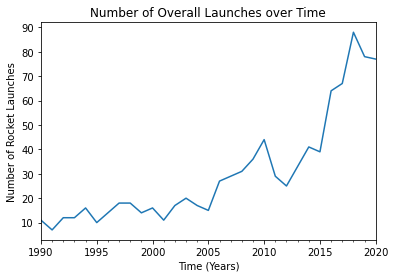

In [50]:
sum_by_year = clean_data.resample('1y', on='Time').sum().reset_index()
sum_by_year.plot(x='Time', y='Launch Count', legend=False)
plt.title('Number of Overall Launches over Time')
plt.xlabel('Time (Years)')
plt.ylabel('Number of Rocket Launches')

As the above plot shows, the number of launches in recent years has skyrocketed. The exponential increase in rocket luanches is evident, but how does this relate to other statistics? Since the goal is to explore success rate, we will now look at the mean success rate of rockets over time. In the below code, a similar resampling is done except this time it uses mean instead of a sum. Then the mean success (where 1 is all successes and 0 is all failures) is plotted against time.

Text(0, 0.5, 'Average Success of Launches (0 to 1 scale)')

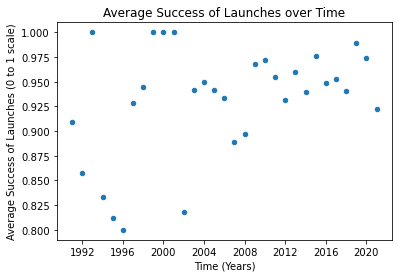

In [51]:
mean_by_year = clean_data.resample('1y', on='Time').mean().reset_index()
mean_by_year.plot.scatter(x='Time', y='Numeric Outcome', legend=False)
plt.title('Average Success of Launches over Time')
plt.xlabel('Time (Years)')
plt.ylabel('Average Success of Launches (0 to 1 scale)')

This plot is interesting as it shows a very broad range of values earlier on, but as it move toward the current day, the value ranges narrow and are more consistent. An initial interpretation for this is that there was a higher variance in rocket success initially, but as we have refined rockets they have become more consistent. However, if we look back at the Number of Launces/Time graph, we can see that the number of rockets in the 1990s was so low, that a high variance in data could be attributed to a lack of data, while more recently 50+ rockets have launched every year resulting in more consistent means. The below code shows that using 10 year means (through a similar resample), there is a clear progression that indicates increased success rates over time.

Text(0, 0.5, 'Average Success of Launches (0 to 1 scale)')

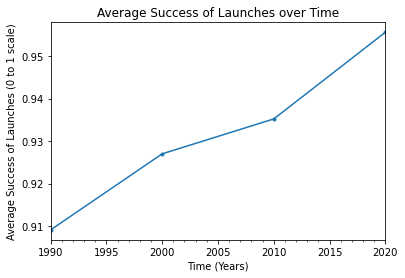

In [52]:
mean_10_years = clean_data.resample('10y', on='Time').mean().reset_index()
mean_10_years.plot(x='Time', y='Numeric Outcome', legend=False, style='.-')
plt.title('Average Success of Launches over Time')
plt.xlabel('Time (Years)')
plt.ylabel('Average Success of Launches (0 to 1 scale)')

We have shown that there is a significant correlation between time and outcome, but what about other variables? Rocket height is often a good indicator of how complex a rocket is and also how expensive it is. However, plotting rocket height on a scale is not so easy, as there is no in built resample function. Instead, I built a custom function that works in a similar way. The downside of this function is that to have the data distributed on an even scale, the data is interpolated. This means that an approximation of the data at every specified point is made, even if there was no data there originally. Ideally with enough data, the interpolation would not have a large impact, but with too little data it could be problematic. Below, I use my function to distribute and approximate the data by mean value, then plot it.

11.6 94.0


Text(0, 0.5, 'Average Success (0 to 1 scale)')

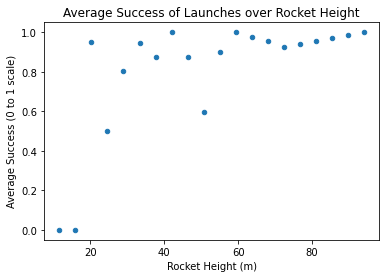

In [53]:
# Make a deepcopy of clean_data so that it is not affected
rocket_height = copy.deepcopy(clean_data)
# Group all the data by height, using mean to group identical rows
rocket_height = rocket_height.groupby('Rocket Height').mean()
# Custom function to resample non-time data
group_price = processing.resample_numeric(rocket_height, 20)
# Plot the result
group_price.plot.scatter(x='index', y='Numeric Outcome')
plt.title('Average Success of Launches over Rocket Height')
plt.xlabel('Rocket Height (m)')
plt.ylabel('Average Success (0 to 1 scale)')

The plot shows a similar situation to what we had with time -- larger rockets tend to have a higher consistency and success rate. However, the extremely linear section near the end is not due to perfect data, but instead the byproduct of interpolation. Since there are very few rockets between 60m and 80m in height, there is little data to work with and all points between data are completely interpolated and result in a line between points. This makes analysis of the data hard, but we still see that the data up to 60m shows an increase in success and a decrease in variation as the rocket height increases. Although this is not the most clear cut plot, it is enough to say that there is some correlation between rocket height and success. It would make sense that this is the case as larger, more expensive rockets would have much more research and development, as well as failsafes put into them, that smaller rockets may lack. On the other hand, there is more to go wrong in a larger more complex rocket, although this plot does not support that claim.

Next, I will look at companies. One interesting factor that could affect success is the experience a company has with launches. To investigate this, I will group the data by company, and then find the average outcome for each company and the total launches (ie. experience). I will then plot the average launches versus total experience.

Text(0, 0.5, 'Average Success (0 to 1 scale)')

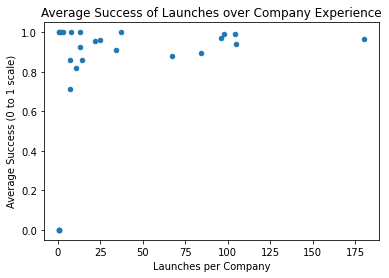

In [54]:
# Make a deepcopy of clean_data so that it is not affected
company = copy.deepcopy(clean_data)
# Group all the data by company, with both mean and sum sets
company_mean = company.groupby('Org').mean()
company_sum = company.groupby('Org').sum()
# Add the total launch count from the summed data to the mean data
company_mean['Launch Count'] = company_sum['Launch Count']
# Plot the result mean result per company over total launches per company
company_mean.plot.scatter(x='Launch Count', y='Numeric Outcome')
plt.title('Average Success of Launches over Company Experience')
plt.xlabel('Launches per Company')
plt.ylabel('Average Success (0 to 1 scale)')

Although the result is not very clear, and there are high levels of success for some companies even at low levels of experience, the overall trend is that companies with more launches tend to have an overall higher success rate. This would definitely make sense, as more experience tends to allow companies to work out flaws and malfunctions.

As shown above, there are clearly some correlations between time, rocket height, company and outcome. I also did some further exploratory data analysis and found some correlation between outcome and other variables, but I am omitting that here so as to hopefully not bore anyone to death. Now we will try to make a predictive model using these correlated variables to determine success of unknown launches. The model I am using is logistic regression, which works well for three main reasons. First, it is great at predicting a binary variable, such as success/failure. Second, it can deal with both categorical and continuous data, which is important considering the dataset I am using. Third, it is a supervised system, meaning it can be targeted to predicting one specific variable instead of learning the data as a whole. To perform logistic regression, I will use the sklearn library which contains tools for splitting training and test data, performing logistic regression, and using it to predict test data.

In [55]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

Next, there is a small amount of formatting needed to prepare the data for logistic regression. An x variable, with all columns used in the regression is formed. Any categorical data is split into 'dummy' columns, where each column represents a categorical value and 1 in the column indicates which categorical value a row has. The numeric outcome, the variable I am training the model to predict, is assigned to a separate variable y. In addition, the data in x is scaled, normalizing and standardizing it to work better.

In [56]:
clean_data = clean_data.dropna()
x = clean_data.drop(columns=['Mission', 'Outcome', 'Time', 'Status', 'Numeric Outcome', 'Location', 'Rocket', 'Org'])
x = x.join(pd.get_dummies(clean_data.Rocket, prefix='Rocket'))
x = x.join(pd.get_dummies(clean_data.Org, prefix='Org'))
x = x.join(pd.get_dummies(clean_data.Location, prefix='Location'))
y = clean_data['Numeric Outcome']
x = scale(x) # For specific info on this function, it is preprocessing.scale()

Now, the logistic regression can be performed. The data is split up into training and test data, a logistic regression instance is created and fit to the training data. Then the numeric outcome for the test data is predicted and compared to the original.

In [57]:
# Split up training and test data and define and instance of a logistic regression
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state=4)
logistic_regression = LogisticRegression()

# Perform the logistic regression on the training data
logistic_regression.fit(x_train, y_train)

# Create a set of predicted outcomes
y_pred = logistic_regression.predict(x_test)

# Compare and output the metrics of the predicted v actual outcomes
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.9607843137254902
Precision: 0.9652605459057072
Recall: 0.9948849104859335


The accuracy is very high, 95-96% (note that because logistic regression uses a random number generator for a minor part of the algorithm, accuracy may vary slightly). However, I can't assume that this model works well without examining exactly what it predicted and where the sources of error were. The below code uses seaborn, a detailed library based on matplotlib, to visualize a confusion matrix. The confusion matrix shows where the model predicted correctly and incorrectly. Crucially, it also tells what cases were correct and incorrect, ie. whether they were successes or fails. 

Text(0.5, 15.0, 'Predicted')

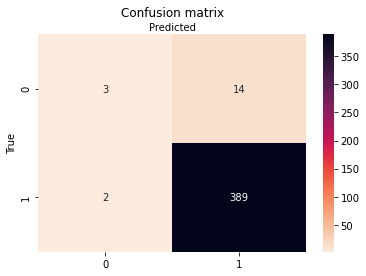

In [59]:
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# create heatmap (there's even a rocket color map!)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="rocket_r", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')

After creating the confusion matrix, I can see that despite having 96% accuracy, the model was not very good at predicting when failures occur. This is primarily because there are very few failures, and so the model can appear to maintain a high level of accuracy even though over 50% of the model's predicted failures were wrong. Perhaps more importanty from a rocket launch standpoint, the model classed many failures as successes.

This is potentially problematic since a model such as this one could be used for risk or safety analysis. Classing successes as failures is the equivalent of a false alarm, an inconvenience but not dangerous. However, classing failures as successes is the equivalent of there being a fire and the alarm not activating, in other words likely to be harmful. Except instead of a fire, it's a giant multi-million dollar aerodynamic cylinder filled with the most efficiently flammable liquids we can find. Not a good prediction to get wrong.

## 4. Conclusion

While there was shown to be correlations between outcome and several other variables, they were not precise enough to generate a predictive model with a high degree of accuracy. It is even arguable that in its current state, the model is dangerous as it may predict a success of a rocket where a failure would in fact occur. Therefore, this model should not be used for risk assesment or any decisions involved with rocket design.

However, this model is not entirely without use and while it is nowhere near accurate enough for risk analysis, it is still interesting as an example of the level of prediction that can be achieved with variables that are not directly related to rocket success. None of these variables were directly related to rocket guidance system faults, manufacturing problems, air temperature (which supposedly caused the o-ring failure in the Challenger disaster) or any others in the variety of technical rocket malfunctions. Instead, these vairables were in the easy to understand and extract category, and to get any predictive success with these variables is great.

Despite a thorough analysis and impelentation of a predictive model, the most time consuming aspect of this project was the data extraction. Initially, I intended to use the list of rockets on nextspaceflight to extract data from, but when I discovered a more detailed page by page listing, I decided it would be worth the extra time to try and extract as much data as I could from this new source. This took a while partially because browsing the html was time consuming, but also running the code to test for bugs and problems took a long time since the data extraction was slow. The end result was worth it because the current code is relatively future proof and will likely work with new and updated data on nextspaceflight. 

Although the current code only determines the accuracy of the model, the web scraping is set up to deal with upcoming launches. It would be relatively simple to predict these upcoming launches based on the logistic regression model. Other possible extensions include trying a different model with the goal of achieving higher predictive accuracy, or trying to find further data about each rocket launch to obtain variables that are better predictors of outcome.